<h1 style="text-align: center;">Predicción de ictus</h1>

<h3 style="text-align: center;">1. Limpieza de datos</h3>

<p style="text-align: center;">Hugo Gálvez</p>

### Libraries needed

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot  as plt
import seaborn as sns
import missingno as msno

### Data Loading

We load the dataset using `pd.read_csv` and check its initial dimensions with `shape`. The `data.info()` method is used to obtain a summary of the columns, data types, and non-null values, and the first rows are displayed with `head()` to inspect the data structure.

In [2]:
# Load dataset
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
print("Dimensiones iniciales del dataset:", data.shape)

# Get basic info
data.info()
display(data.head())

Dimensiones iniciales del dataset: (5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
class_counts = data['stroke'].value_counts().sort_index()
class_percent = data['stroke'].value_counts(normalize=True).sort_index() * 100
summary = pd.DataFrame({'Count': class_counts,
                        '%': class_percent.round(2)})
summary.index.name = 'Stroke'
print(summary)

        Count      %
Stroke              
0        4861  95.13
1         249   4.87


### Missing Values

We process missing values in the dataset:

1. **Calculation of Missing Values**: The percentage of missing values per column is calculated by dividing the number of nulls by the total number of rows (`data.shape[0]`).
2. **Filtering**: Only columns with missing values are identified to focus the analysis on relevant features.
3. **Visualization**: `missingno.matrix` provides a graphical representation of missing values in the dataset, helping to identify patterns or problematic areas.


Null values % by column:
bmi: 3.93%


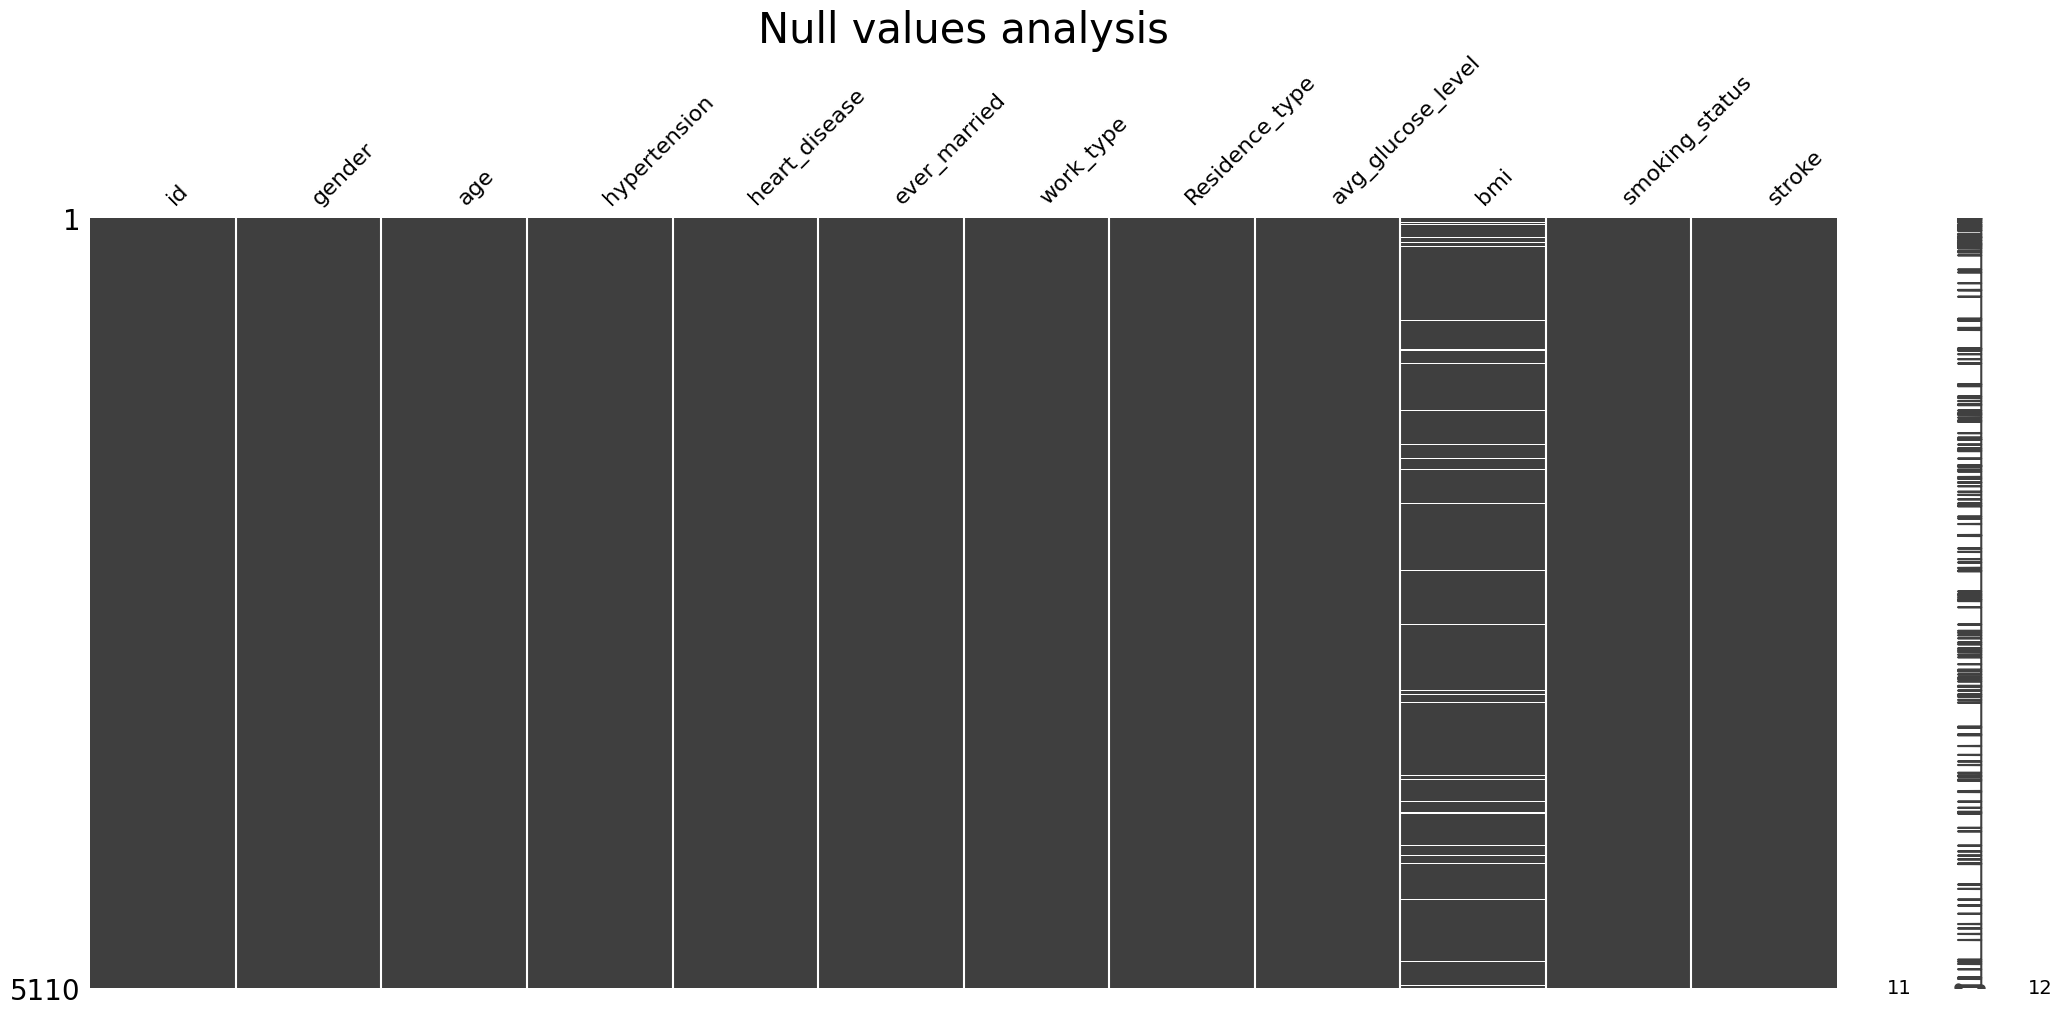

In [4]:
# Calculate percentage of null values
missing_percent = (data.isnull().sum() / data.shape[0]) * 100
missing_filtered = missing_percent[missing_percent > 0]

print("\nNull values % by column:")
for column, percentage in zip(missing_filtered.index, missing_filtered.values):
    print(f"{column}: {percentage:.2f}%")

# Visualization of null values
msno.matrix(data)
plt.title("Null values analysis", fontsize=30)  
plt.show()


The analysis shows that the only column with missing values is `bmi`, with 3.93% missing entries. Visualization confirms that the missing values are uniformly distributed across the dataset, suggesting they are not concentrated in a specific subset. This moderate percentage allows for strategies such as imputation to handle missing values without significantly compromising the dataset size.

In the next block, we remove all rows containing missing values using `dropna(inplace=True)`, which modifies the original dataframe. This reduces the dataset size but ensures that the remaining data is complete, a crucial step to avoid issues during model training for algorithms that do not handle missing data natively. This approach is appropriate given the low percentage of missing values (3.93% in the `bmi` column).

In [5]:
# Delete rows with NAs
data.dropna(inplace=True)
print("Dimensions after removing rows with NAs:", data.shape)

Dimensions after removing rows with NAs: (4909, 12)


We now analyze the `gender` variable to understand its distribution before making any modifications.

1. **Unique Values**: `data['gender'].unique()` displays the categories present, helping to identify outliers or undesired values, such as `Other`.
2. **Visualization**: A bar plot is created using `sns.countplot` to observe the frequency of each category, providing a clear view of its representativeness in the dataset.


Valores únicos en 'gender': ['Male' 'Female' 'Other']


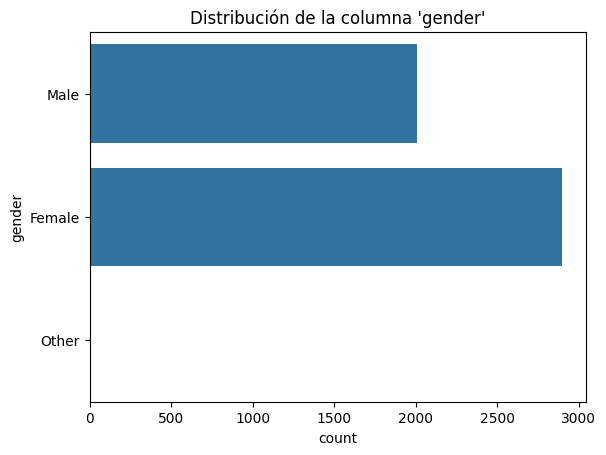

In [6]:
# Análisis de la columna 'gender' antes de eliminar valores no deseados
print("\nValores únicos en 'gender':", data['gender'].unique())
sns.countplot(data['gender'])
plt.title("Distribución de la columna 'gender'")
plt.show()

Eliminating the few values where `gender = Other` is appropriate given their unspecificity and low frequency, which makes it difficult for the model to identify significant patterns associated with this category, especially in an already unbalanced dataset.

In [7]:
# Count rows where 'gender' is 'Other'
count_gender_other = data[data['gender'] == 'Other'].shape[0]
print(f"Number of rows with 'gender = Other': {count_gender_other}")

# Delete rows with 'gender' equal to 'Other'
data = data[data['gender'] != 'Other']
print("Dimensions after removing 'gender = Other':", data.shape)

Number of rows with 'gender = Other': 1
Dimensions after removing 'gender = Other': (4908, 12)


### Variable types

We identify columns with two unique values, an important step in the machine learning context, as these can be converted to Boolean format. This not only simplifies preprocessing, but also optimizes model performance by reducing the complexity of binary categorical variables.

In [8]:
# Checking binary columns for conversion to Boolean
print("\nUnique values per column after cleaning:")
unique_values = data.nunique()
print(unique_values)


Unique values per column after cleaning:
id                   4908
gender                  2
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3851
bmi                   418
smoking_status          4
stroke                  2
dtype: int64


The analysis shows that several columns, such as `gender`, `hypertension`, `heart_disease`, `ever_married`, `Residence_type`, and `stroke`, have exactly two unique values. These are excellent candidates for conversion to boolean format, simplifying the dataset and optimizing it for machine learning models. We store these columns in an object.

In [9]:
# Identify columns with only two unique values for conversion to Boolean
potential_boolean_columns = unique_values[unique_values == 2].index.tolist()
print(f"Candidate columns to be converted to Booleans:",
      f"\n{potential_boolean_columns}")

Candidate columns to be converted to Booleans: 
['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke']


We convert to boolean.

In [10]:
data[potential_boolean_columns] = data[potential_boolean_columns].astype(bool)
print("\nThe following columns have been converted to Booleans:")
print(potential_boolean_columns)


The following columns have been converted to Booleans:
['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke']


We eliminated the `id` column because it has no relevance to the analysis and does not provide predictive value in the context of machine learning. This column is only an identifier and does not contain information that influences the objective of predicting `stroke`.

In [11]:
data.drop(columns=['id'], inplace=True)

We define the numerical and categorical columns of the dataset. The numeric ones (`age`, `avg_glucose_level`, `bmi`) will be used to analyze distributions and calculate relevant statistics, while the categorical ones (`work_type`, `smoking_status`) will be used to explore relationships with the target variable and coding in preprocessing for machine learning models.

In [12]:
# Visualization of numerical distributions
numerical_columns = ['age', 'avg_glucose_level', 'bmi']
categorical_columns = ['work_type', 'smoking_status']
print("\nNumerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns, "\n")


Numerical columns: ['age', 'avg_glucose_level', 'bmi']
Categorical columns: ['work_type', 'smoking_status'] 



### Distribution of variables

We analyze with distribution plots the numerical variables of the dataset. 

We use `sns.histplot` to visualize the frequency of values in each numerical column. The addition of kde = `True` includes a density curve, useful to identify patterns and distribution shapes (symmetric, skewed, etc.). This allows to understand how the values are distributed in the numerical variables and to detect possible problems such as skewness or outliers.

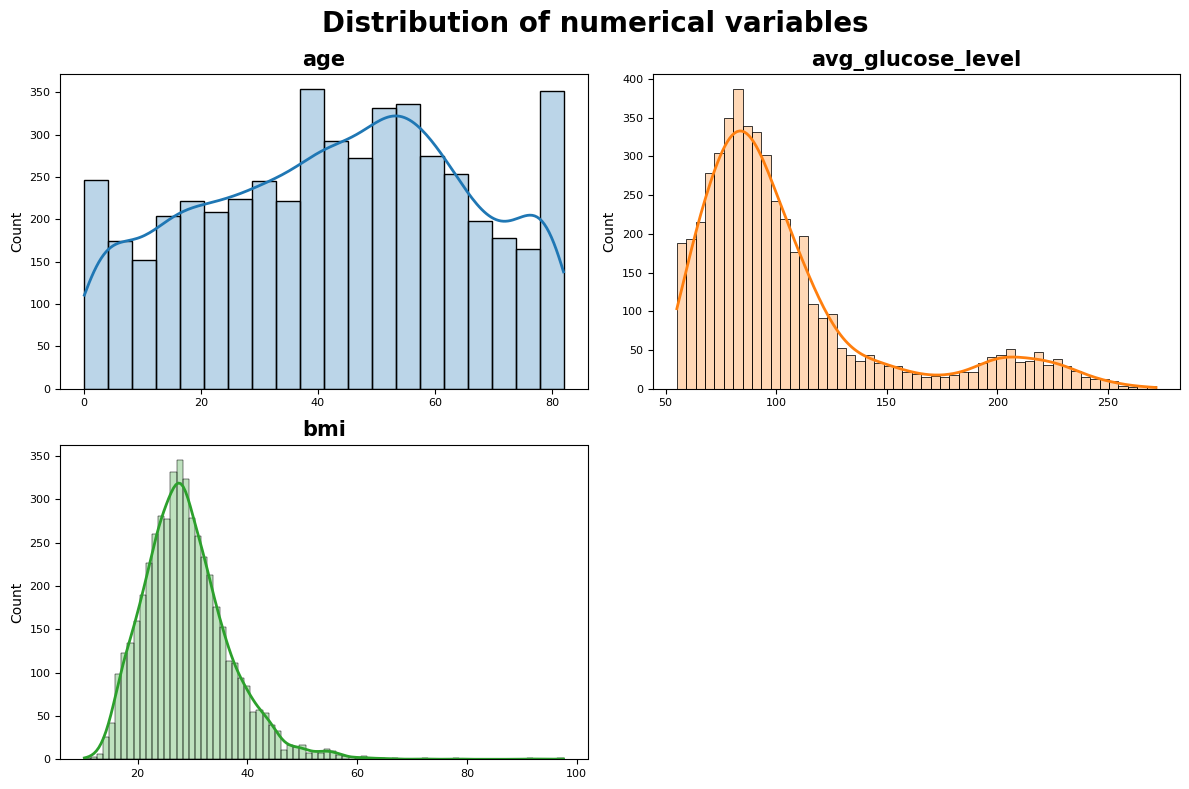

In [13]:
# Configuration of dynamic subplots according to the number of numerical columns
n_cols = 2
# Calculate required rows
n_rows = int(np.ceil(len(numerical_columns) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
axes = axes.flat

for i, colum in enumerate(numerical_columns):
    sns.histplot(
        data     = data,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize=15, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")
    
# If there are subplots left over, turn off the empty axes.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of numerical variables', fontsize=20,
             fontweight="bold")
plt.show()

- `age`: Exhibits a relatively uniform distribution with some peaks at the extremes, indicating diverse representation of age groups within the dataset.  
- `avg_glucose_level`: Shows a right-skewed distribution, suggesting that most values fall within low to moderate ranges, but there are significant higher values.  
- `bmi`: Also displays a right-skewed distribution, with most values concentrated between 20 and 40.  

We now visualize the distributions of categorical variables using bar plots:

`sns.countplot` is used to display the frequency of each category, adding the categorical variable as `hue` to highlight internal differences within each category. These plots help identify dominant categories and potential imbalances in the categorical variables, providing insights for encoding or preprocessing decisions.

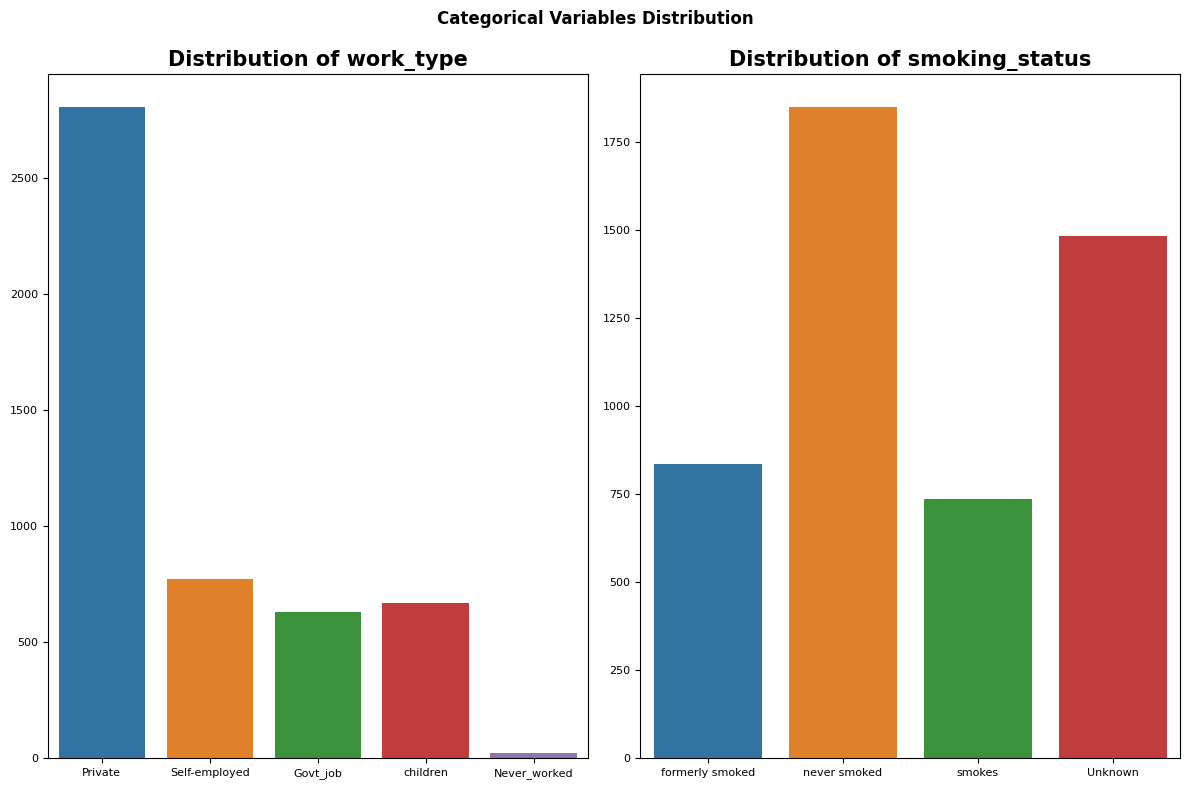

In [14]:
# Distribution chart for each categorical variable
# Dynamic configuration of subplots according to the number of variables
n_cols = 2
n_rows = int(np.ceil(len(categorical_columns) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
axes = axes.flat

for i, colum in enumerate(categorical_columns):
    sns.countplot(
        data=data,
        x=colum,
        hue=colum,
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {colum}", fontsize=15, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Categorical Variables Distribution', fontsize=12, fontweight="bold")
plt.show()

- `work_type`: The `Private` category dominates significantly, while `Never_worked` has very few cases, justifying its removal.  
- `smoking_status`: The `Unknown` category is very frequent, potentially representing missing or non-informative data. This may require specific imputation or treatment depending on its relevance to the analysis.  

These distributions highlight potential imbalances that could influence machine learning models, especially if certain categories are underrepresented.

We analyzed the few cases of `Never_worked`.

In [15]:
# Filter cases with 'work_type' equal to 'never_worked'.
never_worked_cases = data[data['work_type'] == 'Never_worked']

# See how many of them have stroke = 1
never_worked_strokes = never_worked_cases[never_worked_cases['stroke'] == 1]

# Results
print("Total cases with 'work_type = never_worked':", len(never_worked_cases))
print("Cases with 'stroke = 1' and 'work_type = never_worked':",
      len(never_worked_strokes))

Total cases with 'work_type = never_worked': 22
Cases with 'stroke = 1' and 'work_type = never_worked': 0


The elimination of the 22 cases corresponding to the `Never_worked` category in the `work_type` variable is an appropriate decision due to their low representation in the data set (less than 0.5% of the total). This insufficient number of observations limits its ability to contribute meaningful information to the predictive model, especially in a context where the target class (`stroke`) is already unbalanced. In addition, maintaining this category could introduce noise into the analysis and make it difficult to learn relevant patterns, potentially affecting the accuracy and generalization of the model. Its impact on the quality of the analysis is therefore negligible. We proceed to eliminate it.

In [16]:
# Check the distribution of the column 'work_type'.
print("Initial distribution of 'work_type':")
print(data['work_type'].value_counts())

# Eliminate rows with 'never_worked
data.drop(data[data['work_type'] == 'Never_worked'].index, inplace=True)

Initial distribution of 'work_type':
work_type
Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: count, dtype: int64



Distribution after removing 'never_worked':
work_type
Private          2810
Self-employed     775
children          671
Govt_job          630
Name: count, dtype: int64


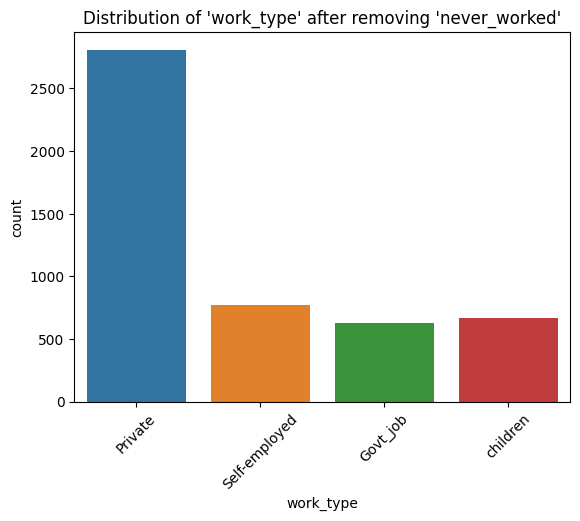

In [17]:
print("\nDistribution after removing 'never_worked':")
print(data['work_type'].value_counts())

sns.countplot(data=data, x='work_type', hue='work_type')
plt.title("Distribution of 'work_type' after removing 'never_worked'")
plt.xticks(rotation=45)
plt.show()

### Final form of the dataset

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4886 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4886 non-null   bool   
 1   age                4886 non-null   float64
 2   hypertension       4886 non-null   bool   
 3   heart_disease      4886 non-null   bool   
 4   ever_married       4886 non-null   bool   
 5   work_type          4886 non-null   object 
 6   Residence_type     4886 non-null   bool   
 7   avg_glucose_level  4886 non-null   float64
 8   bmi                4886 non-null   float64
 9   smoking_status     4886 non-null   object 
 10  stroke             4886 non-null   bool   
dtypes: bool(6), float64(3), object(2)
memory usage: 257.7+ KB


Analysis of the Target Variable `stroke` Distribution

**Frequency Calculation**: Using `value_counts()` counts the number of cases in each class (`0` and `1`), while `normalize=True` calculates percentages, making it easier to interpret the class imbalance.

This analysis is crucial for understanding the imbalance in the target variable, which may necessitate techniques like oversampling (e.g., SMOTENC) or undersampling to improve model performance.

In [19]:
class_counts = data['stroke'].value_counts().sort_index()
class_percent = data['stroke'].value_counts(normalize=True).sort_index() * 100

# Crear un DataFrame resumen
summary = pd.DataFrame({
    'Count': class_counts,
    '%': class_percent.round(2)
})

summary.index.name = 'Stroke'
print(summary)

        Count      %
Stroke              
False    4677  95.72
True      209   4.28


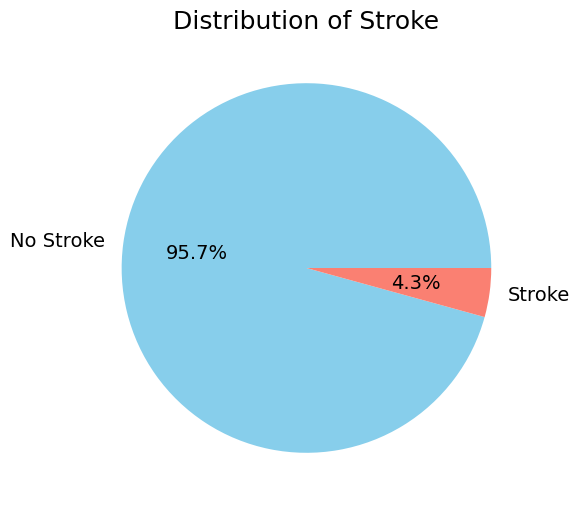

In [20]:
# Count the occurrences of each value in the 'stroke' column
stroke_distribution = data['stroke'].value_counts()

# Pie chart for stroke distribution with larger font sizes
plt.figure(figsize=(8, 6))
stroke_distribution.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    textprops={'fontsize': 14},  # Increase font size for labels
    labels=['No Stroke', 'Stroke'],  # Custom labels
)
plt.title('Distribution of Stroke', fontsize=18)
plt.ylabel('')  # Remove y-axis label
plt.show()

The results confirm a strong imbalance in the target variable `stroke`, where only **4.28%** of the cases correspond to patients who have suffered a stroke (`True`). This imbalance can negatively impact the performance of machine learning models, favoring the prediction of the majority class (`False`).

To address this challenge, `SMOTENC` **(Synthetic Minority Oversampling Technique for Nominal and Continuous variables)** will be implemented to balance the classes. This technique generates synthetic samples considering both categorical and numerical features in the training set, preserving the integrity of the test set and avoiding data leakage. This strategy is preferred over undersampling, as removing data from the majority class could lead to the loss of important information. Although the dataset contains `4886` records, the positive cases (`stroke = True`) are only 209, making it a small dataset for this specific task, and highlighting the importance of utilizing all available information.

### Outlier Analysis

In this section, we will explore the presence of outliers. Outliers can negatively influence model performance, especially in algorithms sensitive to these values, such as Artificial Neural Networks or decision trees.

To achieve this:
- We will visualize the data using boxplots, which allow for graphical identification of outliers.
- We will calculate outliers using the interquartile range (IQR), establishing upper and lower bounds to detect potential extreme values.
- A summary will be generated with the count of outliers per variable to analyze their potential impact on the data.

This analysis will help us make informed decisions regarding the treatment of outliers, whether by removing, transforming, or retaining them in the dataset.

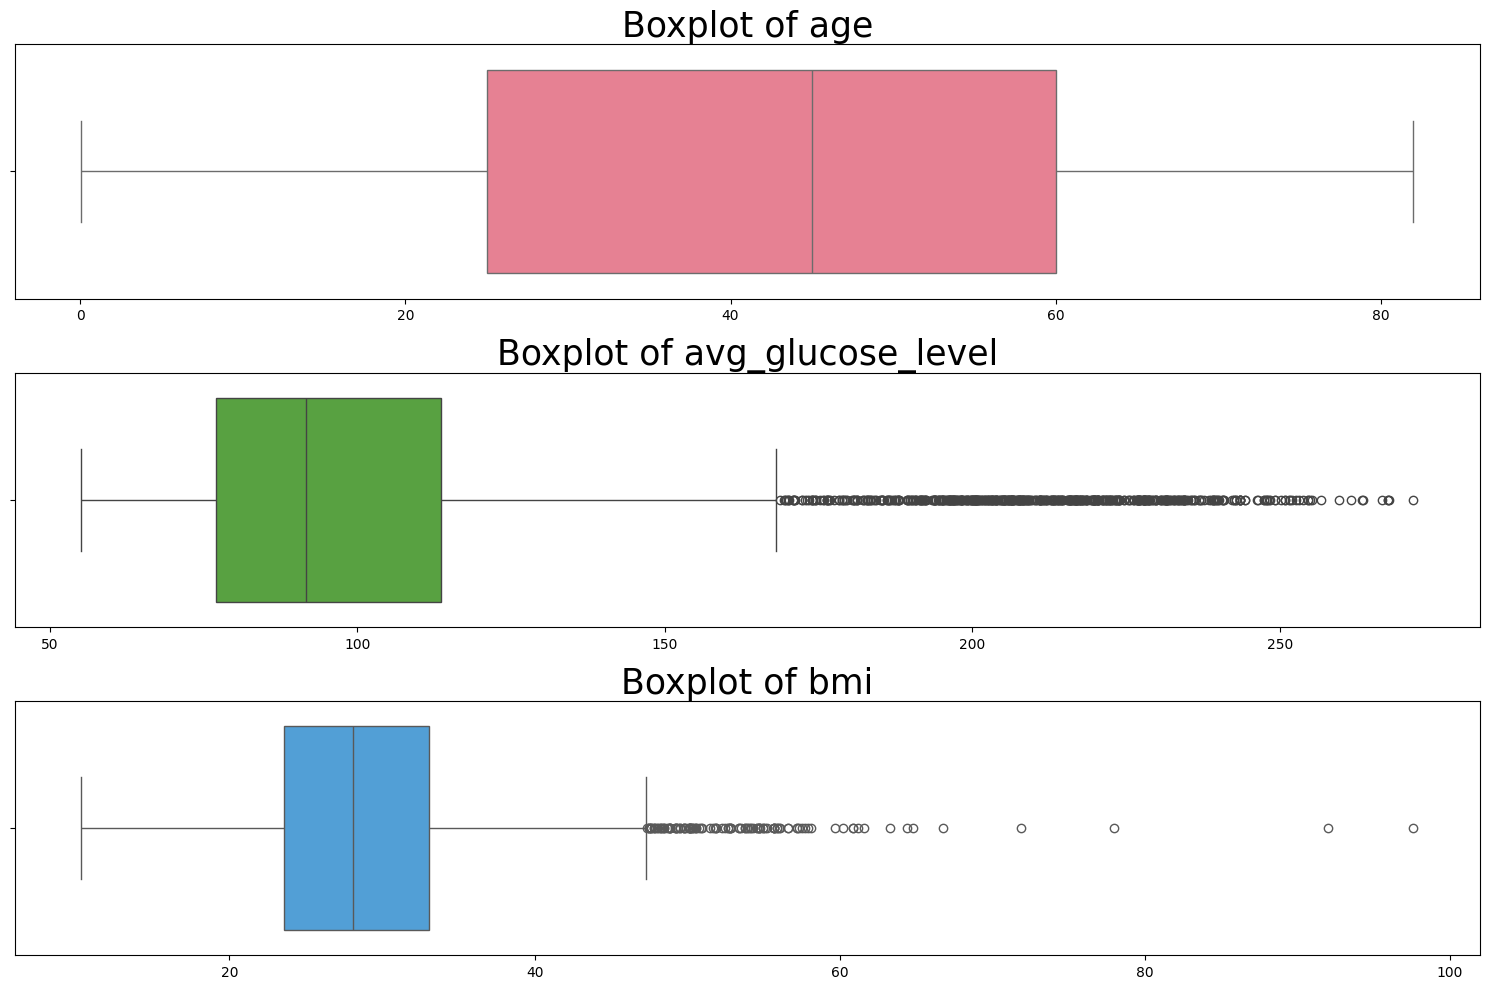


Outlier summary:
                   lower_bound  upper_bound  outlier_count
age                  -27.50000    112.50000            0.0
avg_glucose_level     22.33875    168.26875          567.0
bmi                    9.35000     47.35000          114.0


In [21]:
# Explore numerical variables
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Boxplots to identify outliers with different colors
colors = sns.color_palette("husl", len(numerical_columns))
plt.figure(figsize=(15, 10))
for i, (column, color) in enumerate(zip(numerical_columns, colors), 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(data=data, x=column, color=color)
    plt.title(f'Boxplot of {column}', fontsize=25)
    plt.xlabel("")
plt.tight_layout()
plt.show()

# Calculate outliers using IQR
outlier_summary = {}
for column in numerical_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    outlier_summary[column] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_count': len(outliers),
    }

# Outlier summary
outlier_summary_df = pd.DataFrame(outlier_summary).T

# Display outlier summary and categorical variables
print("\nOutlier summary:")
print(outlier_summary_df)

In [22]:
# Top 10 highest values of avg_glucose_level
top_glucose = data.nlargest(10, 'avg_glucose_level')
print("Top 10 highest values of avg_glucose_level:")
print(top_glucose)

# Top 10 highest values of bmi
top_bmi = data.nlargest(10, 'bmi')
print("\nTop 10 highest values of bmi:")
print(top_bmi)

Top 10 highest values of avg_glucose_level:
      gender   age  hypertension  heart_disease  ever_married      work_type  \
193     True  68.0          True           True          True        Private   
1207    True  49.0         False          False          True        Private   
3088    True  76.0         False          False          True  Self-employed   
4983    True  76.0          True          False          True        Private   
2462    True  60.0         False          False          True       Govt_job   
3393    True  67.0          True          False          True       Govt_job   
135     True  71.0         False          False          True       Govt_job   
4457    True  62.0          True          False          True  Self-employed   
122     True  80.0         False          False          True        Private   
4470    True  28.0         False          False          True        Private   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
19

After analyzing the outliers in the numerical variables, the following decisions were made:

Variable `avg_glucose_level`:  
   - Several values were identified as outliers according to the interquartile range (IQR).  
   - However, among these values, there are records with `stroke=True`, making them relevant for the model's objective (stroke prediction).  
   - Additionally, since the dataset already exhibits a class imbalance, removing these records could further reduce the number of positive cases available for training. For this reason, it was decided to **retain all records**.  

Variable `bmi`:  
   - Outliers were also identified, though not as extreme as in `avg_glucose_level`.  
   - The decision to keep these values is based on the uncertainty regarding their potential relevance in stroke prediction. Removing these records could eliminate important patterns that have not yet been identified.  
   - Furthermore, the `bmi` variable typically has a wide range in diverse populations, which justifies retaining the observed values.  

The dataset is saved for use in subsequent analyses.

In [23]:
# Save the cleaned dataset to the working directory
# data.to_csv('cleaned_healthcare_dataset.csv', index=False)
# print("Cleaned dataset saved as 'cleaned_healthcare_dataset.csv'")

# Referencias

- Angermueller, C., Pärnamaa, T., Parts, L., & Stegle, O. (2016). Deep learning for computational biology. *Molecular systems biology*, 12(7), 878.

- Bosch Rué, A., Casas Roma, J., & Lozano Bagén, T. (2019). *Deep Learning: Principios y Fundamentos*. Editorial UOC. Retrieved from [here](http://www.editorialuoc.com).

- Codecademy. (2024). *Normalization*. Retrieved from [here](https://www.codecademy.com/article/normalization).

- DataCamp. (2024). *Normalization in Machine Learning*. Retrieved from [here](https://www.datacamp.com/tutorial/normalization-in-machine-learning).

- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. *Computing in Science & Engineering*, 9(3), 90-95. doi: 10.1109/MCSE.2007.55.

- IBM. (2024). *Jupyter Notebook Markdown Cheatsheet*. Retrieved from [here](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet).

- Keras. (2024). *Keras Examples*. Retrieved from [here](https://keras.io/examples/).

- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436-444. DOI: 10.1038/nature14539.

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Scikit-learn: Machine Learning in Python. (2011). *Journal of Machine Learning Research*, 12, 2825-2830.

- TensorFlow. (2024). *tf.keras.utils.plot_model*. Retrieved from [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

- Waskom, M. L. (2021). seaborn: statistical data visualization. *Journal of Open Source Software*, 6(60), 3021. [DOI](https://doi.org/10.21105/joss.03021).

- Machine Learning with Python and Scikit-learn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

- Calibrate machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py11-calibrar-modelos-machine-learning).

- Machine Learning with Python and Scikitlearn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Multiple linear regression with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py10b-regresion-lineal-multiple-python).

- Using pandas category to encode categorical variables in machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py55-pandas-category-modelos-machine-learning). 

- OpenAI Community. (2025). *Issue with accessing 'choices' attribute from OpenAI API response*. Retrieved from [here](https://community.openai.com/t/issue-with-accessing-choices-attribute-from-openai-api-response/362725).

- Ebbelaar, D. (2025). *Streamlit Chatbot Interface*. GitHub Repository. Retrieved from [here](https://github.com/daveebbelaar/streamlit-chatbot-interface/tree/main).

- OpenAI Community. (2025). *Content is a required property error (400)*. Retrieved from [here](https://community.openai.com/t/content-is-required-property-error-400/486260/2).

- Stack Overflow. (2025). *Save SHAP summary plot as PDF/SVG*. Retrieved from [here](https://stackoverflow-com.translate.goog/questions/52137579/save-shap-summary-plot-as-pdf-svg?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es-419&_x_tr_pto=sc).

- SHAP Documentation. (2025). *Overview of SHAP*. Retrieved from [here](https://shap.readthedocs.io/en/latest/overviews.html).

- Stack Overflow. (2025). *Using Python's eval() vs ast.literal_eval()*. Retrieved from [here](https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval).

- PyPI. (2025). *missingno: Missing Data Visualization Module*. Retrieved from [here](https://pypi.org/project/missingno/). 